# Hands-on Lesson 10 - Deep reinforcement learning - corrected #

In this hands-on lesson, we will use a neural network to control an autonomous car.   

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# tensorflow 
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model

# To play animations
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display

## Autonomous car environement ##

In this environement, an autonomous car drives on a loop. Its goal is to finish the loop without touching the road borders.
The road is between $r_{int}$ and $r_{ext}$ defined in polar coordinates as
$$ r_{int} = R_{int}\left(1 + \epsilon \cos n_1\theta + \epsilon \sin n_2\theta\right)$$
$$ r_{ext} = R_{ext}\left(1 + \epsilon \cos n_1\theta + \epsilon \sin n_2\theta\right)$$

In [3]:
# PARAMETERS
N1 = 5
N2 = 3
RINT = 1
REXT = 1.5
REPS = 0.05
NSENSORS = 2

class autonomous_car:  
    def __init__(self):
        self.reset()
        self._fill_archive()
        
    def reset(self):
        self.rcar = (self._rint(0) + self._rext(0)) / 2 
        self.thetacar = 0
        self.phicar = np.pi/2
        self.rcararchive = []
        self.thetacararchive = []
        self.statearchive = []
        self.rarchive = []
        self.tarchive = []
        self._xy()
        state, _, _ = self._state()
        return state 

    def step(self, action):
        # Possible actions
        if action == 0: # STRAIGHT
            pas = 1
        if action == 1: # RIGHT
            self.phicar -= np.pi/10
            pas = 0.5
        if action == 2: # LEFT
            self.phicar += np.pi/10
            pas = 0.5
        if action == 3: # RIGHT
            self.phicar -= np.pi/20
            pas = 0.75
        if action == 4: # LEFT
            self.phicar += np.pi/20
            pas = 0.75
            
        self._xy()
        xnew = self.xcar + 0.1 * pas * np.cos(self.phicar)
        ynew = self.ycar + 0.1 * pas * np.sin(self.phicar)
        rcarnew = np.sqrt(xnew**2 + ynew**2)
        thetacarnew = np.arctan2(ynew,xnew)
        thetacarnew = np.remainder(thetacarnew + 0.3, 2*np.pi) - 0.3

        # Reward
        done = False
        reward = thetacarnew - self.thetacar 
        if thetacarnew > 1.65*np.pi:
            done = True
            reward = 10
        if rcarnew < self._rint(thetacarnew):
            done = True
            reward = -1
        if rcarnew > self._rext(thetacarnew):
            done = True
            reward = -1
            
        self.rcar = rcarnew
        self.thetacar = thetacarnew   
        state = self._fill_archive()
        return state, reward, done
            
    def _rint(self,theta):
        return RINT * (1 + REPS*(np.cos(N1*theta)+np.sin(N2*theta)))

    def _rext(self,theta):
        return REXT * (1 + REPS*(np.cos(N1*theta)+np.sin(N2*theta)))
    
    def _fill_archive(self):
        self.rcararchive.append(self.rcar)
        self.thetacararchive.append(self.thetacar)
        state, r, t = self._state()
        self.statearchive.append(state)
        self.rarchive.append(r)
        self.tarchive.append(t)
        return state
        
    def _xy(self):
        self.xcar = self.rcar * np.cos(self.thetacar)
        self.ycar = self.rcar * np.sin(self.thetacar)

    def _state(self):
        # theta = self.phicar + np.pi/2 + np.pi/6 * np.array((-1,1)).reshape(-1,1)  # SENSOR ANGLES  
        theta = self.phicar + np.pi/2 + np.pi/6 * np.linspace(-1,1, num=NSENSORS).reshape(-1,1)  # SENSOR ANGLES  
        theta_line =  self.thetacar + (theta - np.pi/2 - self.thetacar) * np.arange(0, 0.95, 0.01)
        
        rint = self.rcar * np.cos(self.thetacar - theta) / np.cos(theta_line - theta) - self._rint(theta_line)
        rext =-self.rcar * np.cos(self.thetacar - theta) / np.cos(theta_line - theta) + self._rext(theta_line)
        rint[:,-1] = -1
        rext[:,-1] = -1
        index = np.minimum(np.argmax(rint<0,axis=1), np.argmax(rext<0,axis=1))

        thetaborder = np.zeros(NSENSORS)
        for j in range(NSENSORS):
            thetaborder[j] = theta_line[j,index[j]]
        rborder = self.rcar * np.cos(self.thetacar - theta[:,0]) / np.cos(thetaborder - theta[:,0])
        
        x = rborder * np.cos(thetaborder)
        y = rborder * np.sin(thetaborder)
        d = np.sqrt((x - self.xcar)**2 + (y - self.ycar)**2)
        return d, rborder, thetaborder
    
    #__ rendering animation ________________________________   
    
    def render(self):
        theta = np.linspace(0, 2 * np.pi, num=100)
        fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
        ax.plot(theta, self._rint(theta),'r')
        ax.plot(theta, self._rext(theta),'r')
        ax.plot(1.65 * np.pi * np.ones(2), [self._rint(1.65 * np.pi), self._rext(1.65 * np.pi)], 'k:')
        fig_car, = ax.plot([], [], 'ok')
        fig_sense = []
        for j in range(NSENSORS):
            data, = ax.plot([], [], 'b')
            fig_sense.append(data)
        ax.grid(False)
        plt.axis('off')

        def animate(i):
            fig_car.set_data(self.thetacararchive[i], self.rcararchive[i])
            ax.set_title(str(self.statearchive[i]))
            for j in range(NSENSORS):
                fig_sense[j].set_data(
                    [self.thetacararchive[i], self.tarchive[i][j]], 
                    [self.rcararchive[i], self.rarchive[i][j]])
            return fig_car, # fig_sense,

        anim = FuncAnimation(
            fig, 
            animate,
            frames=len(self.rarchive),
            interval=100,
            blit=True
        ) 
        return anim

Let's play with this environment with a random walk

In [4]:
myenv = autonomous_car()
myenv.reset()
for _ in range(20):
    action = np.random.randint(5)
    state, reward, done = myenv.step(action)
    print("state, action, reward, done", state, action, reward, done)
    if done: break

state, action, reward, done [0.55240942 1.87406577] 4 0.05688695791598064 False
state, action, reward, done [0.44576976 1.55725411] 3 0.05722185820557335 False
state, action, reward, done [0.34727599 0.81216463] 1 0.03418420743295947 False
state, action, reward, done [0.36281754 1.38265262] 2 0.036936410561844435 False
state, action, reward, done [0.42515315 1.76496441] 2 0.0371893638048314 False
state, action, reward, done [0.49749936 0.7864258 ] 4 0.055215321331464895 False
state, action, reward, done [0.34056671 1.4033845 ] 1 0.03749620347319027 False
state, action, reward, done [0.32764655 1.32370957] 0 0.0735724926366762 False
state, action, reward, done [0.24604674 0.89128541] 3 0.05054746995029058 False
state, action, reward, done [0.20429867 0.65392624] 0 0.06382255278420007 False
state, action, reward, done [0.15088943 0.82621355] 4 0.04880530310988407 False
state, action, reward, done [0.08879261 0.15933565] 3 0.04296485822710472 False
state, action, reward, done [0.075 0.075

In [5]:
anim = myenv.render()
display(HTML(anim.to_jshtml(default_mode='reflect')))
plt.close() 

## Deep Q-learning algorithm

In [24]:
class Qnetwork(Model):
    def __init__(self, Nstates, Nhidden, Nactions):
        super(Qnetwork, self).__init__()
        self.input_layer = layers.InputLayer(input_shape = (Nstates,))
        self.dense1 = layers.Dense(Nhidden, activation='tanh')
        self.dense2 = layers.Dense(Nactions, activation='linear')

    @tf.function
    def call(self, inputs, **kwargs):
        x = self.input_layer(inputs)
        x = self.dense1(x)
        x = self.dense2(x)
        return x

    
class Qlearning():
    def __init__(self, Nstates, Nhidden, Nactions, LearningRate):
        self.model = Qnetwork(Nstates, Nhidden, Nactions)
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=LearningRate, )
        self.loss = tf.keras.losses.MeanSquaredError()
        
    def Qvalues(self, state):        
        return self.model(state)
    
    def action(self, state):        
        q_values = self.model(state)
        return np.argmax(q_values[0])  
    
    @tf.function
    def train(self, state, Qtarget):
        train_variables = self.model.trainable_variables
        with tf.GradientTape() as tape:
            Qoutput = self.model(state)
            loss = self.loss(Qtarget, Qoutput)
        
        gradients = tape.gradient(loss, train_variables)
        self.optimizer.apply_gradients(zip(gradients, train_variables))
        return loss

Now, let's try to train this network to control the car. 

In [7]:
N_STATES = NSENSORS
N_ACTIONS = 3
N_HIDDEN = 4
LEARNING_RATE = 0.003
DISCOUNT_FACTOR = 0.99
N_EPISODES = 1001
EPSILON = 0.9

myenv = autonomous_car()
myqlearning = Qlearning(
    Nstates=N_STATES, 
    Nhidden=N_HIDDEN, 
    Nactions=N_ACTIONS, 
    LearningRate=LEARNING_RATE)
step = 0
list_fullrewards = []

for episode in range(N_EPISODES):
    # initial state
    s = myenv.reset()
    total_reward = 0
    EPSILON *= 0.9975
    
    while True:
        # epsilon-greedy policy
        a = myqlearning.action(s[np.newaxis,:])
        if np.random.rand(1) < EPSILON:
            a = np.random.randint(N_ACTIONS)
        s_, r, done = myenv.step(a)
        
        Qtarget = myqlearning.Qvalues(s[np.newaxis,:])
        Q_ = myqlearning.Qvalues(s_[np.newaxis,:])
        maxQ_ = np.max(Q_[0])
        Qtarget = np.array(Qtarget)
        Qtarget[0,a] = r + DISCOUNT_FACTOR * maxQ_
        myqlearning.train(s[np.newaxis,:], Qtarget)
        s = s_
        total_reward += r
        if done:
            break
    
    list_fullrewards.append(total_reward)

    if episode % 100 == 0:
        print("Episode: ", episode, "  // epsilon: ", EPSILON, "  // Total reward: ", total_reward)

Episode:  0   // epsilon:  0.89775   // Total reward:  -0.7304390797254197
Episode:  100   // epsilon:  0.6989495822916731   // Total reward:  0.48975182939848105
Episode:  200   // epsilon:  0.5441721176114787   // Total reward:  2.002528322233906
Episode:  300   // epsilon:  0.42366903291486324   // Total reward:  3.4134320412022756
Episode:  400   // epsilon:  0.3298505080320368   // Total reward:  15.179552335470376
Episode:  500   // epsilon:  0.2568074350405888   // Total reward:  15.162931823250752
Episode:  600   // epsilon:  0.1999392363698308   // Total reward:  15.155178547464516
Episode:  700   // epsilon:  0.15566409996592523   // Total reward:  15.128811762677625
Episode:  800   // epsilon:  0.12119338083986932   // Total reward:  15.169337551847189
Episode:  900   // epsilon:  0.09435595980455848   // Total reward:  1.8910287129245242
Episode:  1000   // epsilon:  0.07346149673308394   // Total reward:  15.174307500139532


## Some questions now
- Plot an animation of the greedy policy
- Plot the function $a = \pi^*(s)$
- Plot the evolution of the loss/total reward as learning is implemented
- Play with the parameters (learning rate, hidden layers, number of neurons, etc.)
- Try to see if learning is better/faster with more sensors
- Try to play with the rewards to see if learning is better/faster
- Try to see if the car can learn different tracks
- Try to see if the car can learn random tracks
- Could you code learning with "experience replay" (i.e. mini-batch descent)?

In [8]:
myenv = autonomous_car()
state = myenv.reset()
for _ in range(200):
    action = myqlearning.action(state[np.newaxis,:])
    state, reward, done = myenv.step(action)
    print("state, action, reward, done", state, action, reward, done)
    if done: break

state, action, reward, done [0.6206211  0.46310507] 2 0.03664590298413256 False
state, action, reward, done [0.46774548 1.641074  ] 1 0.03842411550778613 False
state, action, reward, done [0.5593968  0.63623614] 2 0.037672270443361244 False
state, action, reward, done [0.78659833 0.33954309] 2 0.03437048961488104 False
state, action, reward, done [0.53934031 0.77755392] 1 0.039185736572318386 False
state, action, reward, done [0.76075867 0.33992526] 2 0.03651497148778815 False
state, action, reward, done [0.52273642 1.69048236] 1 0.04034706717197578 False
state, action, reward, done [0.51592237 1.63285037] 0 0.0810621257222659 False
state, action, reward, done [0.46958959 1.50044453] 0 0.08066967907841982 False
state, action, reward, done [0.57878704 0.52708561] 2 0.03978128168704287 False
state, action, reward, done [0.61051798 0.61038605] 0 0.08102786620339913 False
state, action, reward, done [0.57848537 1.60281433] 0 0.08212750149170267 False
state, action, reward, done [0.5509782 

In [10]:
anim = myenv.render()
display(HTML(anim.to_jshtml()))
plt.close() 

In [17]:
ss = np.linspace(0,2,20)
S1, S2 = np.meshgrid(ss, ss)
A = np.zeros(S1.shape)

for i, s1 in enumerate(ss):
    for j, s2 in enumerate(ss):
        state = np.array([s1, s2])
        action = myqlearning.action(state[np.newaxis,:])
        A[i, j] = action

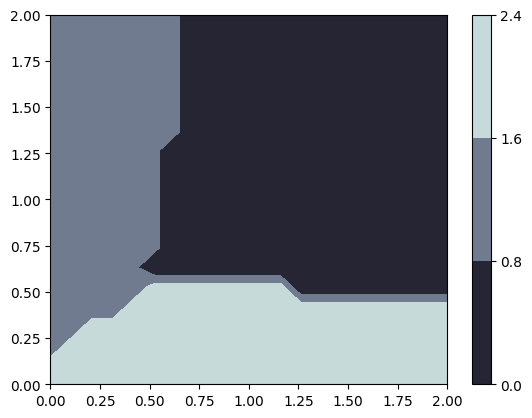

In [22]:
plt.figure()
cs = plt.contourf(S1, S2, A, N_STATES, cmap=plt.cm.bone)
plt.colorbar(cs)
plt.show()

In [30]:
N_STATES = NSENSORS
N_ACTIONS = 3
N_HIDDEN = 4
LEARNING_RATE = 0.003
DISCOUNT_FACTOR = 0.99
N_EPISODES = 1001
EPSILON = 0.9

myenv = autonomous_car()
myqlearning = Qlearning(
    Nstates=N_STATES, 
    Nhidden=N_HIDDEN, 
    Nactions=N_ACTIONS, 
    LearningRate=LEARNING_RATE)
step = 0
list_fullrewards = []

losses = []
rewards = []
for episode in range(N_EPISODES):
    # initial state
    s = myenv.reset()
    total_reward = 0
    total_loss = 0
    EPSILON *= 0.9975
    
    while True:
        # epsilon-greedy policy
        a = myqlearning.action(s[np.newaxis,:])
        if np.random.rand(1) < EPSILON:
            a = np.random.randint(N_ACTIONS)
        s_, r, done = myenv.step(a)
        
        Qtarget = myqlearning.Qvalues(s[np.newaxis,:])
        Q_ = myqlearning.Qvalues(s_[np.newaxis,:])
        maxQ_ = np.max(Q_[0])
        Qtarget = np.array(Qtarget)
        Qtarget[0,a] = r + DISCOUNT_FACTOR * maxQ_
        loss = myqlearning.train(s[np.newaxis,:], Qtarget)
        s = s_
        total_reward += r
        total_loss += loss
        if done:
            rewards.append(total_reward)
            losses.append(total_loss)
            break
    
    list_fullrewards.append(total_reward)

    if episode % 100 == 0:
        print("Episode: ", episode, "  // epsilon: ", EPSILON, "  // Total reward: ", total_reward)

Episode:  0   // epsilon:  0.89775   // Total reward:  -0.5225120971790707
Episode:  100   // epsilon:  0.6989495822916731   // Total reward:  -0.339623744511625
Episode:  200   // epsilon:  0.5441721176114787   // Total reward:  0.468084097988436
Episode:  300   // epsilon:  0.42366903291486324   // Total reward:  0.9708897573004054
Episode:  400   // epsilon:  0.3298505080320368   // Total reward:  0.9581939374804482
Episode:  500   // epsilon:  0.2568074350405888   // Total reward:  0.26805775132276666
Episode:  600   // epsilon:  0.1999392363698308   // Total reward:  0.26088158505742287
Episode:  700   // epsilon:  0.15566409996592523   // Total reward:  15.162140166082855
Episode:  800   // epsilon:  0.12119338083986932   // Total reward:  15.177117703896183
Episode:  900   // epsilon:  0.09435595980455848   // Total reward:  15.171556683819404
Episode:  1000   // epsilon:  0.07346149673308394   // Total reward:  15.177441311271489


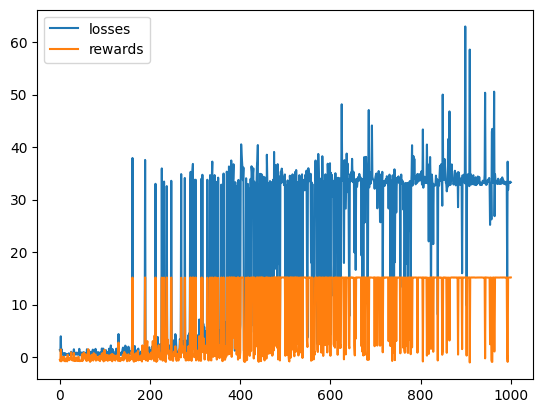

In [31]:
plt.figure()
plt.plot(losses, label="losses")
plt.plot(rewards, label="rewards")
plt.legend()
plt.show()

In [38]:
# with experience replay
N_STATES = NSENSORS
N_ACTIONS = 3
N_HIDDEN = 4
LEARNING_RATE = 0.003
DISCOUNT_FACTOR = 0.99
N_EPISODES = 401
EPSILON = 0.9
N_BATCH = 10  # number of samples in mini-batches
N_EXPERIENCES = 1000  # number of experiences in the bank

myenv = autonomous_car()
myqlearning = Qlearning(
    Nstates=N_STATES, 
    Nhidden=N_HIDDEN, 
    Nactions=N_ACTIONS, 
    LearningRate=LEARNING_RATE)
step = 0
list_fullrewards = []

losses = []
rewards = []
experiences = []
for episode in range(N_EPISODES):
    # initial state
    s = myenv.reset()
    total_reward = 0
    total_loss = 0
    if len(experiences) >= N_EXPERIENCES:    
        EPSILON *= 0.99
    
    while True:
        # epsilon-greedy policy
        a = myqlearning.action(s[np.newaxis,:])
        if np.random.rand(1) < EPSILON:
            a = np.random.randint(N_ACTIONS)
        s_, r, done = myenv.step(a)
        Q_ = myqlearning.Qvalues(s_[np.newaxis,:])
        maxQ_ = np.max(Q_[0])
        experiences += [[s, a, r, maxQ_]]
        
        if len(experiences) > N_EXPERIENCES:
            del experiences[0]
            assert len(experiences) == N_EXPERIENCES, "Problem with the length of experiences"
            
            for _ in range(N_BATCH):
                i = np.random.choice(N_EXPERIENCES)
                experience = experiences[i]
                si = experience[0]
                ai = experience[1]
                ri = experience[2]
                mi = experience[3]
        
                Qtarget = myqlearning.Qvalues(si[np.newaxis,:])
                Qtarget = np.array(Qtarget)
                Qtarget[0, ai] = ri + DISCOUNT_FACTOR * mi
                loss = myqlearning.train(si[np.newaxis,:], Qtarget)
                total_loss += loss / N_BATCH
                
        s = s_
        total_reward += r
        
        if done:
            rewards.append(total_reward)
            losses.append(total_loss)
            break
    
    list_fullrewards.append(total_reward)

    if episode % 20 == 0:
        print(
            "Episode: ", episode, 
            "  // experiences: ", len(experiences), 
            "  // epsilon: ", EPSILON, 
            "  // Total reward: ", total_reward
        )

Episode:  0   // experiences:  38   // epsilon:  0.9   // Total reward:  0.8472309626005436
Episode:  20   // experiences:  367   // epsilon:  0.9   // Total reward:  -0.5177833470805662
Episode:  40   // experiences:  682   // epsilon:  0.9   // Total reward:  -0.3937373770183046
Episode:  60   // experiences:  1000   // epsilon:  0.9   // Total reward:  0.3611953204937357
Episode:  80   // experiences:  1000   // epsilon:  0.7361162438375077   // Total reward:  -0.4972561780584164
Episode:  100   // experiences:  1000   // epsilon:  0.6020745827127124   // Total reward:  1.9041495481576787
Episode:  120   // experiences:  1000   // epsilon:  0.49244097815168514   // Total reward:  -0.6956781344562206
Episode:  140   // experiences:  1000   // epsilon:  0.40277089238742964   // Total reward:  15.159354759616367
Episode:  160   // experiences:  1000   // epsilon:  0.3294291071459063   // Total reward:  2.595396296078691
Episode:  180   // experiences:  1000   // epsilon:  0.26944235218

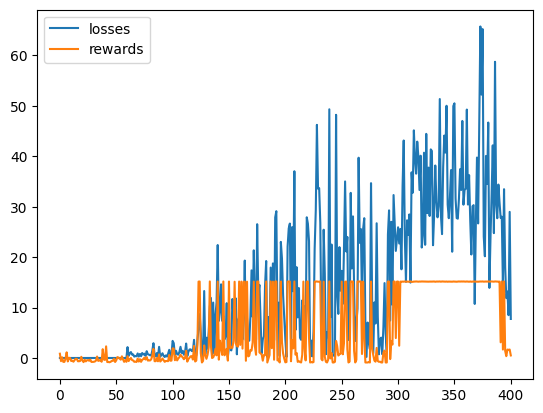

In [39]:
plt.figure()
plt.plot(losses, label="losses")
plt.plot(rewards, label="rewards")
plt.legend()
plt.show()